##  Random forest with the injected data set 
Run Random Forest Classifier against Kelsey's August 17, 2024 run.
This involved injected signals into ~20,000 light curves which were then searched with BLS

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

### Read in the data from Kelsey's file

In [2]:
ddir = "data/MLClassifier20240817/"
tcefile = "injlog_rec_PC_train_14-08-2024.csv"
columns = ["pass","win","type","injNum","period","tzero","power","dur","depth","snr","deptest1","deptest2",
           "stmass","stradius","chisq",
           "bicft","bicplus","bicminus",
           "snrshape","noise",
           "depth_shape2","depth_shape3","mindBIC",
           "nloops","npoints",
           "nintransit",
           "fscale","photerror","chisqtrap","chisqFourier","chisqRamp1","chisqRamp2",
           "Tmag","Teff","logg","injnum", "injPer", "injTo", "injSNR", "injrec", "label", "trprob"]
tces = pd.read_csv(ddir+tcefile, names=columns)

# Note that lable is a 0/1 binary and inrec is now a continuum indicating how well it matched the original ephemeris of the target.
# A split of about 0.7 seems to catc most of them.

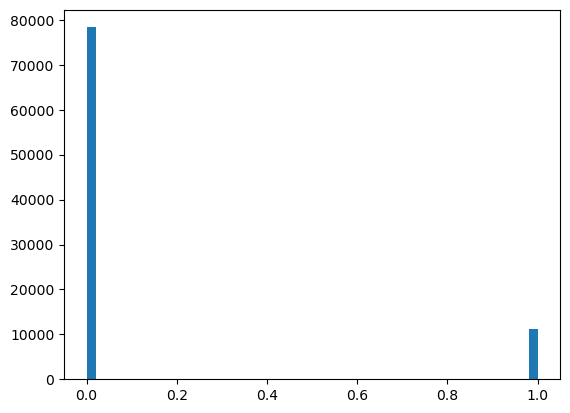

In [3]:
ans = plt.hist(tces['label'],50)

In [4]:
# This is how well Jason's RF runs written as a confusion matrix
#Originally Jason/Kelsey Confusion Matrix
injected = tces['label'] == 1

for prob in np.arange(0.1,1,.2):
    jasonpassed = tces['trprob'] > prob  #This is arbitrary

    num00 = len(tces[~injected & ~jasonpassed])
    num01 = len(tces[~injected & jasonpassed])
    num10 = len(tces[injected & ~jasonpassed])
    num11 = len(tces[injected & jasonpassed])

    print("   ==>  For the Probability %f:" % prob)
    #print([num00,num01],"\n",[num10,num11])

    print(100*np.array([num00,num01])/(num00+num01),"\n",
          100*np.array([num10,num11])/(num10+num11))

   ==>  For the Probability 0.100000:
[97.63272078  2.36727922] 
 [  0. 100.]
   ==>  For the Probability 0.300000:
[99.4295559  0.5704441] 
 [ 2.31332619 97.68667381]
   ==>  For the Probability 0.500000:
[99.86855539  0.13144461] 
 [ 4.77849232 95.22150768]
   ==>  For the Probability 0.700000:
[9.99910669e+01 8.93312915e-03] 
 [ 8.58342265 91.41657735]
   ==>  For the Probability 0.900000:
[100.   0.] 
 [17.24723115 82.75276885]


# Choose parameters to train the Random Forest.

88089 89556


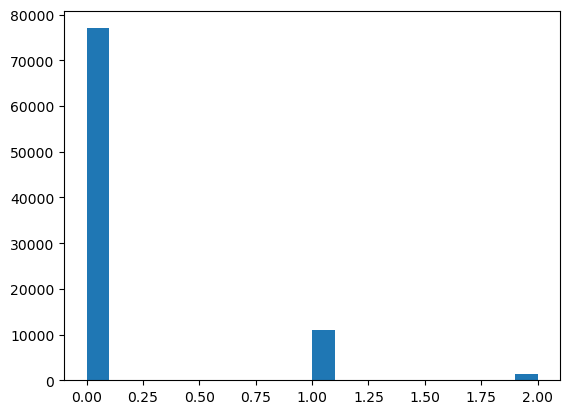

In [26]:
#Define the good and bad labels, rejecting those that sit in the middle, meaning they have contamination from the injections.
Slabels = np.ones(len(tces)) + 1
Slabels[tces['injrec'] > 0.75] = 1
Slabels[tces['injrec'] < 0.001] = 0

tces['Slabels'] = Slabels

#This limits which to use, but use Kelsey's lables in keeptces.
keep = tces['Slabels'] < 1.9
keeptces = tces[keep].copy(deep=True)
print(len(keeptces), len(tces))

ans = plt.hist(Slabels, 20)

#Pick metrics
metrics=["period",
         #"power",
         "dur",
         #"depth","snr",
         "deptest1","deptest2",
         "chisq",
         "bicft","bicplus","bicminus","snrshape","noise","depth_shape2","depth_shape3",
         "mindBIC","nloops",
         "npoints",
          "nintransit",
          "fscale",
         "photerror","chisqtrap",
         #"chisqFourier","chisqRamp1","chisqRamp2",
         #"Tmag", "logg", "Teff"
         ]



X = np.array(keeptces[metrics])
X[~np.isfinite(X)] = -9999

#Here we define the test and training sets using a routine written by Scikitlearn
X_train, X_test, y_train, y_test = train_test_split(X, keeptces['label'], test_size=0.3)

In [27]:
rf = RandomForestClassifier(n_estimators=40,max_depth=None, min_samples_split=2, random_state=0)
rf.fit(X_train, y_train)
scores= cross_val_score(rf, X_train, y_train, cv=6)
print("Cross Validation Score mean: %f" % scores.mean())

Cross Validation Score mean: 0.989880


In [28]:
tces.columns

Index(['pass', 'win', 'type', 'injNum', 'period', 'tzero', 'power', 'dur',
       'depth', 'snr', 'deptest1', 'deptest2', 'stmass', 'stradius', 'chisq',
       'bicft', 'bicplus', 'bicminus', 'snrshape', 'noise', 'depth_shape2',
       'depth_shape3', 'mindBIC', 'nloops', 'npoints', 'nintransit', 'fscale',
       'photerror', 'chisqtrap', 'chisqFourier', 'chisqRamp1', 'chisqRamp2',
       'Tmag', 'Teff', 'logg', 'injnum', 'injPer', 'injTo', 'injSNR', 'injrec',
       'label', 'trprob', 'Slabels'],
      dtype='object')

## Test Set Confusion Matrix

Accuracy: 0.9907670185794831


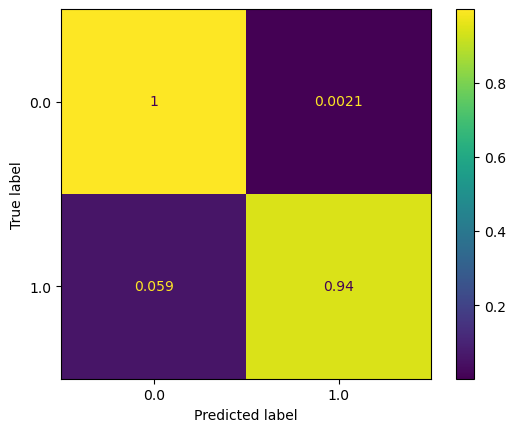

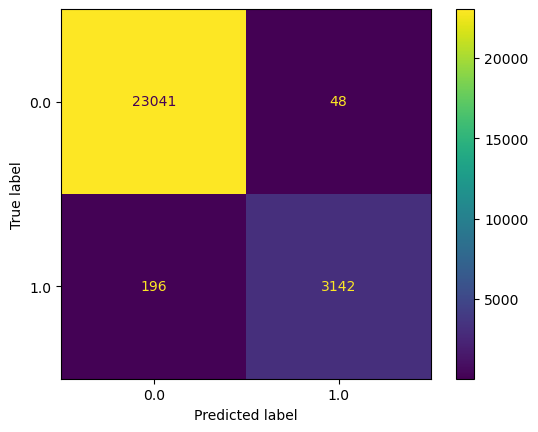

In [29]:
# Get back confusion matrix for the text set.

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#cm = confusion_matrix(y_pred=y_pred, y_true = y_test)

_ = ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)

## ROC and probability.
Receiver operator curve would be good to see as well.
Then we could also get an idea of confidence

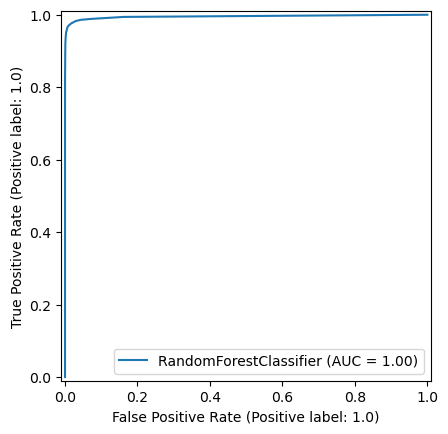

In [30]:
svc_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)

In [31]:
#Get ROC SCORE FROM  TEST SET
from sklearn.metrics import roc_auc_score
y_prob = rf.predict_proba(X)
y_test_prob = rf.predict_proba(X_test)
roc_auc_score(y_test, y_test_prob[:,1])

0.9951634194002883

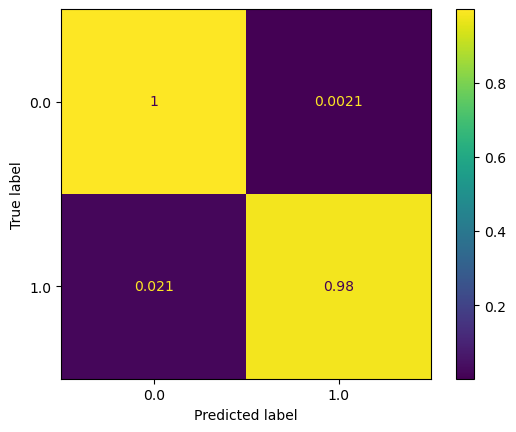

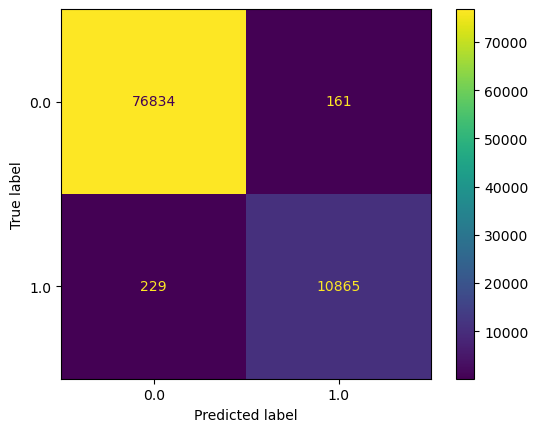

In [32]:
#Confusion matrix cross the entire data set.
_ = ConfusionMatrixDisplay.from_estimator(rf, X, keeptces['Slabels'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, X, keeptces['Slabels'])

In [33]:
#Record the results in the TCEs for the entire data set.
y_all = rf.predict(X)
y_prob = rf.predict_proba(X)

keeptces['newRF'] = y_all
keeptces['newRFprob'] = y_prob[:,1]  #Probability it is class "transit"

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

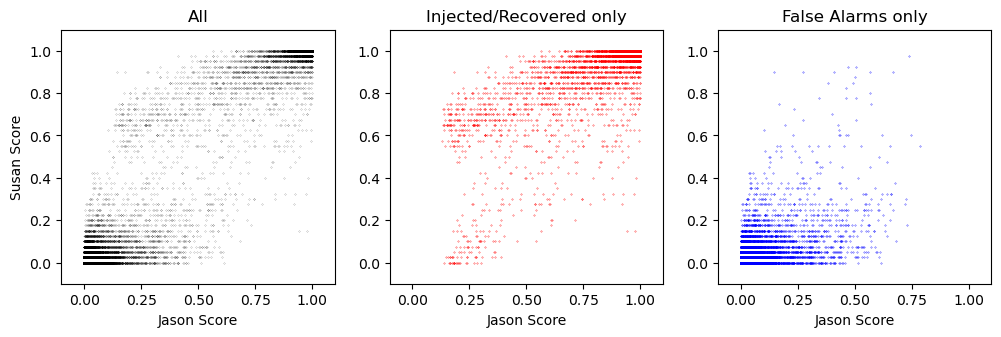

In [34]:
#Compare to Jason's RF for individual cases.
injected = keeptces['label'] == 1
falsepos = keeptces['label'] == 0

plt.figure(figsize=(12,3.3))
plt.subplot(131)
plt.plot(keeptces['trprob'], keeptces['newRFprob'],'.k', ms=0.2)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.ylabel('Susan Score')
plt.title("All")

plt.subplot(132)
plt.plot(keeptces[injected]['trprob'],keeptces[injected]['newRFprob'], '.r',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('Injected/Recovered only')

plt.subplot(133)
plt.plot(keeptces[falsepos]['trprob'],keeptces[falsepos]['newRFprob'], '.b',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('False Alarms only')
plt.tight_layout

In [35]:
## What sort of features are most important
isort = np.argsort(rf.feature_importances_)
for i,m in enumerate(metrics):
    print(m, 100*rf.feature_importances_[i])

period 3.9591957176813333
dur 1.6517605848829713
deptest1 7.654085121404589
deptest2 9.01976043419403
chisq 2.6637301046753863
bicft 3.0305679714413216
bicplus 3.8187230567665527
bicminus 2.622416204478039
snrshape 8.67773068007416
noise 0.4335288993977686
depth_shape2 20.10559418654366
depth_shape3 26.639560111243988
mindBIC 1.4681977913785897
nloops 0.7302476909311626
npoints 1.7160159352280009
nintransit 2.6397561644470704
fscale 1.719214118507512
photerror 0.40345148148167614
chisqtrap 1.0464637452421903


# Understand where I differ in classification

In [36]:
want = (keeptces[injected]['trprob'] < 0.5) & (keeptces[injected]['newRFprob'] > 0.5)

wanttces = keeptces[injected][want]
print(len(wanttces))

392


"\nplt.subplot(241)\nans = plt.hist(keeptces[injected]['period'], nbins, density=True)\nplt.title('period')\nplt.subplot(245)\nans2 = plt.hist(wanttces['period'], ans[1], color='red')\nplt.subplot(242)\n\nplt.subplot(246)\nans = plt.hist(wanttces['dur'], nbins)\n\nplt.title('duration')\nplt.subplot(243)\nans = plt.hist(wanttces['snr'], nbins)\nplt.title('snr')\nplt.subplot(244)\nans =plt.hist(wanttces['Tmag'], nbins)\nplt.title('Tmag')"

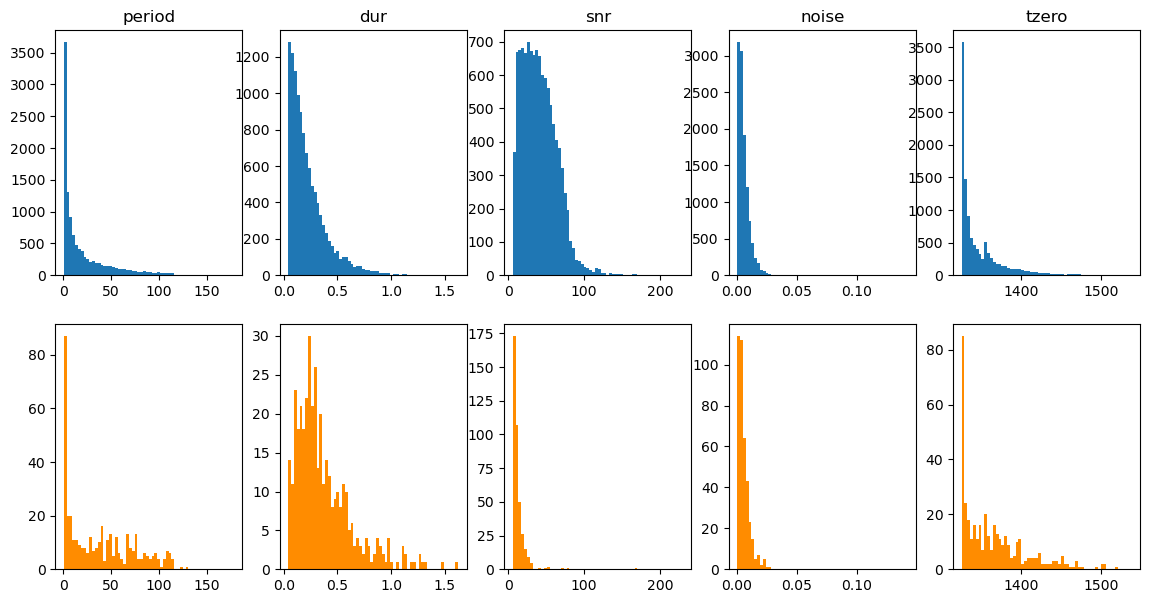

In [71]:
nbins = 60
params = ['period', 'dur','snr','noise','tzero']   #Must be 2,3,4,5,6,7
plt.figure(figsize=(14,7))

numpar= len(params)

for i,aparam in enumerate(params):
    plt.subplot(2,numpar,i+1)
    ans = plt.hist(keeptces[injected][aparam], nbins, density=False)
    plt.title(aparam)
    plt.subplot(2,numpar,i+1+numpar)
    ans2 = plt.hist(wanttces[aparam], ans[1], color='darkorange', density=False)



In [64]:
len(params)

4

## Conclusions
We seem to be still doing better for some population of injected/recovered compared to Jasons's random forest.
I get an accuracy of 99% with a 94% recovery of the labeled set.

## Let's iterate from the above below
Here is a space to run different versions to see how it goes.
I'll keep notes here

1) Relax the 0/1 labels to 0.8 and 0.1: 93% recovered and .3% contamintion in the test set wihti cross validation of .989.
2) Just use Kelsey's labels: on test set 95% and 0.3%, cross validation .9889, this also only shows improvement from Kelsey's labels compared to mine.
3) Keeping Kelsey's lables and now changing metrics (add in chisq metrics) increase nestimators to 60 :.99 cross validation, 94% recovered 0.2% contamination.
4) Let's keep high nestimators and lots of metrics but restrict which true positives to use (0.92 and .02), but using Kelsey's labels in that set: .99 cross contamination and 94% recovers and .2% contamination.
5) Restrict some of the useless metrics, 0.8 and 0.01 for restricting which to use: 

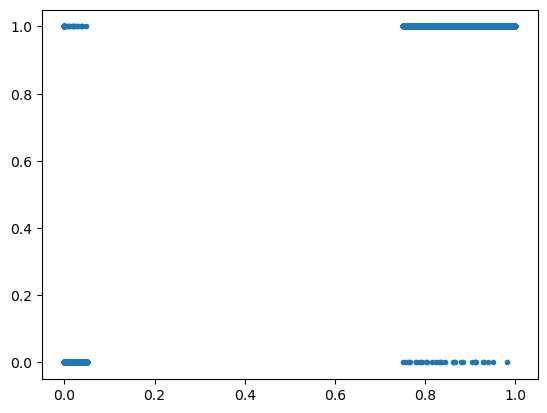

In [15]:
plt.plot(tces['injrec'],tces['label'],'.')

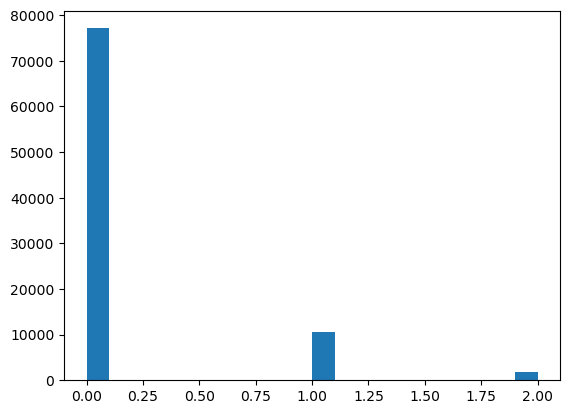

In [16]:
#Define the good and bad labels, rejecting those that sit in the middle, meaning they have contamination from the injections.
Slabels = np.ones(len(tces)) + 1
Slabels[tces['injrec'] > 0.8] = 1
Slabels[tces['injrec'] < 0.01] = 0

#tces['Slabels'] = tces['label']

#This limits which to use, but use Kelsey's lables in keeptces.
keep = tces['Slabels'] != 2

ans = plt.hist(Slabels, 20)

#Pick metrics
metrics=["period",
         #"power",
         "dur",
         #"depth","snr",
         "deptest1","deptest2",
         "chisq",
         "bicft","bicplus","bicminus","snrshape","noise","depth_shape2","depth_shape3",
         "mindBIC","nloops",
         "npoints",
          "nintransit",
          "fscale",
         #"photerror","chisqtrap","chisqFourier","chisqRamp1","chisqRamp2",
         #"Tmag", "logg", "Teff"
         ]

keeptces = tces[keep].copy(deep=True)

X = np.array(keeptces[metrics])
X[~np.isfinite(X)] = -9999

#Here we define the test and training sets using a routine written by Scikitlearn
X_train, X_test, y_train, y_test = train_test_split(X, keeptces['label'], test_size=0.3)

In [17]:
rf = RandomForestClassifier(n_estimators=60,max_depth=None, min_samples_split=2, random_state=0)
rf.fit(X_train, y_train)
scores= cross_val_score(rf, X_train, y_train, cv=6)
print("Cross Validation Score mean: %f" % scores.mean())

Cross Validation Score mean: 0.991008


In [18]:
tces.columns

Index(['pass', 'win', 'type', 'injNum', 'period', 'tzero', 'power', 'dur',
       'depth', 'snr', 'deptest1', 'deptest2', 'stmass', 'stradius', 'chisq',
       'bicft', 'bicplus', 'bicminus', 'snrshape', 'noise', 'depth_shape2',
       'depth_shape3', 'mindBIC', 'nloops', 'npoints', 'nintransit', 'fscale',
       'photerror', 'chisqtrap', 'chisqFourier', 'chisqRamp1', 'chisqRamp2',
       'Tmag', 'Teff', 'logg', 'injnum', 'injPer', 'injTo', 'injSNR', 'injrec',
       'label', 'trprob', 'Slabels'],
      dtype='object')

## Test Set Confusion Matrix

Accuracy: 0.9915847993298301


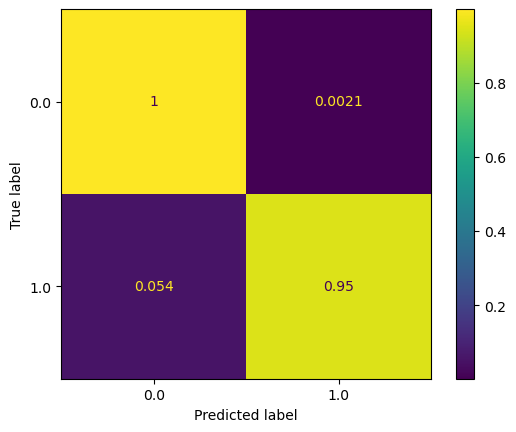

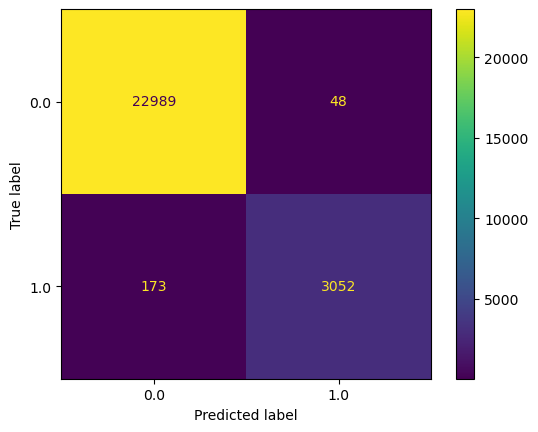

In [19]:
# Get back confusion matrix for the text set.

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#cm = confusion_matrix(y_pred=y_pred, y_true = y_test)

_ = ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)

## ROC and probability.
Receiver operator curve would be good to see as well.
Then we could also get an idea of confidence

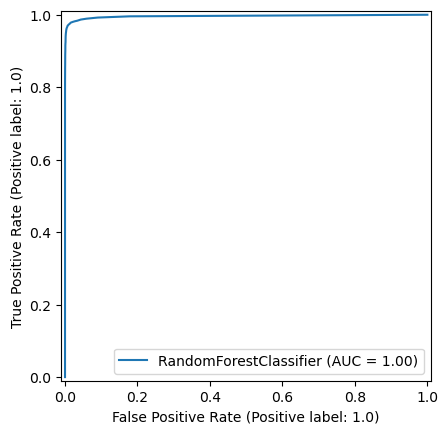

In [20]:
svc_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)

In [21]:
#Get ROC SCORE FROM  TEST SET
from sklearn.metrics import roc_auc_score
y_prob = rf.predict_proba(X)
y_test_prob = rf.predict_proba(X_test)
roc_auc_score(y_test, y_test_prob[:,1])

0.9960951122444415

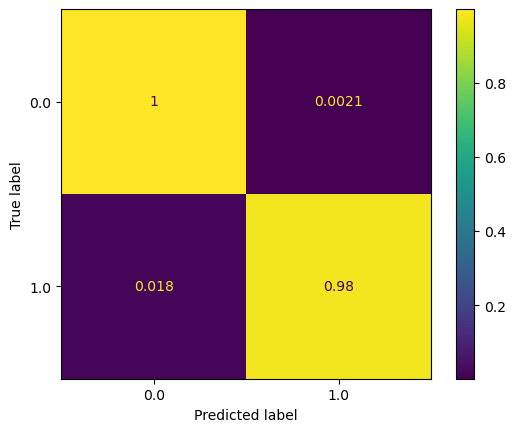

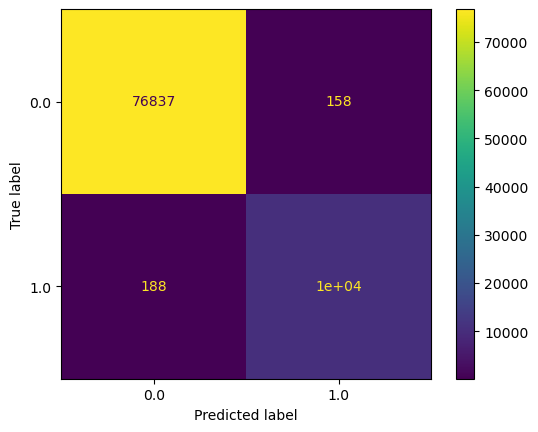

In [22]:
#Confusion matrix cross the entire data set.
_ = ConfusionMatrixDisplay.from_estimator(rf, X, keeptces['Slabels'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, X, keeptces['Slabels'])

In [23]:
#Record the results in the TCEs for the entire data set.
y_all = rf.predict(X)
y_prob = rf.predict_proba(X)

keeptces['newRF'] = y_all
keeptces['newRFprob'] = y_prob[:,1]  #Probability it is class "transit"

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

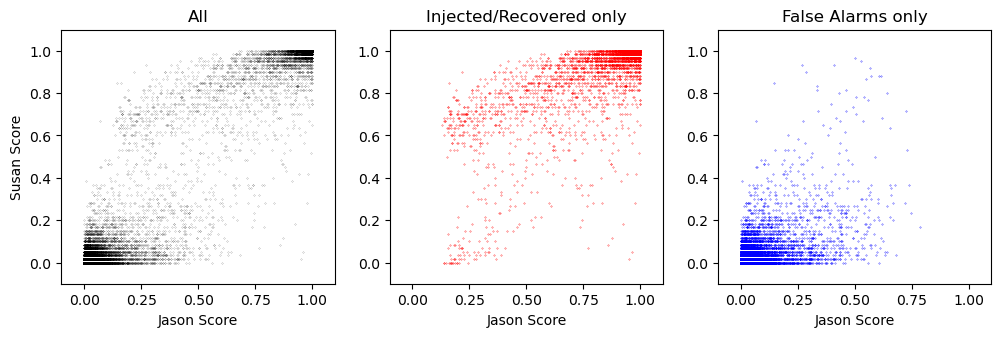

In [24]:
#Compare to Jason's RF for individual cases.
injected = keeptces['label'] == 1
falsepos = keeptces['label'] == 0

plt.figure(figsize=(12,3.3))
plt.subplot(131)
plt.plot(keeptces['trprob'], keeptces['newRFprob'],'.k', ms=0.2)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.ylabel('Susan Score')
plt.title("All")

plt.subplot(132)
plt.plot(keeptces[injected]['trprob'],keeptces[injected]['newRFprob'], '.r',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('Injected/Recovered only')

plt.subplot(133)
plt.plot(keeptces[falsepos]['trprob'],keeptces[falsepos]['newRFprob'], '.b',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('False Alarms only')
plt.tight_layout

In [25]:
## What sort of features are most important
isort = np.argsort(rf.feature_importances_)
for i,m in enumerate(metrics):
    print(m, 100*rf.feature_importances_[i])

period 3.4622501823708274
dur 1.9684604411968745
deptest1 12.521994565060393
deptest2 4.394751747104371
chisq 2.2280173197761997
bicft 8.69080143293271
bicplus 4.042090862790091
bicminus 2.598020476802694
snrshape 7.532070955552688
noise 0.47401585636781707
depth_shape2 14.933734803078591
depth_shape3 26.141538967884774
mindBIC 3.2747471471428327
nloops 0.9524896837189514
npoints 1.4131284340856496
nintransit 3.6237666545545637
fscale 1.7481204695799821
